In [3]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

In [4]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

In [5]:
read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

In [6]:
arts_fy11 = pd.read_csv('../input/ARTS_Passenger_Data_FY11.csv.gz', **read_csv_opts)
arts_fy12 = pd.read_csv('../input/ARTS_Passenger_Data_FY12.csv.gz', **read_csv_opts)
arts_fy13 = pd.read_csv('../input/ARTS_Passenger_Data_FY13.csv.gz', **read_csv_opts)
arts_fy14 = pd.read_csv('../input/ARTS_Passenger_Data_FY14.csv.gz', **read_csv_opts)
arts_fy15 = pd.read_csv('../input/ARTS_Passenger_Data_FY15.csv.gz', **read_csv_opts)
arts_fy16 = pd.read_csv('../input/ARTS_Passenger_Data_FY16.csv.gz', **read_csv_opts)
arts_fy17 = pd.read_csv('../input/ARTS_Passenger_Data_FY17.csv.gz', **read_csv_opts)
arts_fy18 = pd.read_csv('../input/ARTS_Passenger_Data_FY18.csv.gz', **read_csv_opts)
arts_fy19 = pd.read_csv('../input/ARTS_Passenger_Data_FY19.csv.gz', **read_csv_opts)

In [7]:
files = [arts_fy11,
         arts_fy12,
         arts_fy13,
         arts_fy14,
         arts_fy15,
         arts_fy16,
         arts_fy17,
         arts_fy18,
         arts_fy19]

In [8]:
# Concatenating DataFrames converts 'category' columns back to 'object' when new values introduced
df = pd.concat(files)

In [9]:
df_obj = df.select_dtypes(include=['object']).copy()

In [10]:
converted_obj = pd.DataFrame()

for col in df_obj.columns:
    num_unique_values = len(df_obj[col].unique())
    num_total_values = len(df_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = df_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = df_obj[col]

In [11]:
df[converted_obj.columns] = converted_obj

In [12]:
# We can convert columns back to 'category' type but resulting DataFrame is bigger than sum of FY DataFrames.
# May be better to work on each FY separately?
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1763020 entries, 0 to 37258
Data columns (total 43 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                category
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City       

In [13]:
len(set(df['MissionID']))

14973

In [14]:
len(set(df['AlienMasterID']))

1733555

In [15]:
df['MissionDate'].min()

Timestamp('2010-10-01 00:00:00')

In [16]:
df['MissionDate'].max()

Timestamp('2018-12-05 00:00:00')

In [17]:
df['air_AirportName'].value_counts().head(10)

Alexandria International Airport                        239911
Brownsville South Padre Island International Airport    204895
Phoenix-Mesa-Gateway Airport                            196150
Valley International Airport                            154138
El Paso International Airport                           136127
San Antonio International Airport                       107434
Columbus Metropolitan Airport                            80797
Harrisburg International Airport                         76348
Laredo International Airport                             56409
Miami International Airport                              55588
Name: air_AirportName, dtype: int64

In [18]:
df['air2_AirportName'].value_counts().head(10)

La Aurora Airport                                       327010
Ramon Villeda Morales International Airport             202955
Alexandria International Airport                        169316
El Salvador International Airport                       157773
Valley International Airport                            148700
Phoenix-Mesa-Gateway Airport                             93892
El Paso International Airport                            87408
Licenciado Benito Juarez International Airport           85584
Brownsville South Padre Island International Airport     66444
San Diego International Airport                          62943
Name: air2_AirportName, dtype: int64

In [19]:
with open('../../share/hand/clean.yaml', 'r') as yamlfile:
    clean = yaml.load(yamlfile)

In [20]:
df['R-T'] = df['R-T'].replace(clean['R-T'])
df['R-T'] = df['R-T'].astype('category')
df['R-T'].value_counts()

R             1263646
T              499353
Ineligible          2
No-show             1
Name: R-T, dtype: int64

In [21]:
df['Sex'] = df['Sex'].replace(clean['Sex'])
df['Sex'] = df['Sex'].astype('category')
df['Sex'].value_counts()

M    1618577
F     144302
U        137
Name: Sex, dtype: int64

In [22]:
df['Criminality'] = df['Criminality'].replace(clean['Criminality'])
df['Criminality'] = df['Criminality'].astype('category')
df['Criminality'].value_counts()
df['NonCriminal'] = df['Criminality'] == 'NC'

In [23]:
# This column had a bunch of random-seeming numeric strings, replace removes any string that's just numbers
# I checked and there were no '13' or '15' or '18' values before replace
# Numeric strings didn't seem to be result of data shifted into column but need to investigate more
df['GangMember'] = df['GangMember'].str.replace('^[0-9]*$', '')
df['GangMember'] = df['GangMember'].astype('category')
df['GangMember'].value_counts().head(10)

N       1079547
No       243020
NO       120228
NONE      91863
Y         10891
None       8675
no         5201
           4960
Yes        1677
n          1061
Name: GangMember, dtype: int64

In [24]:
# This field seems pretty clean, look for duplicates due to spelling or style
df['CountryOfCitizenship'] = df['CountryOfCitizenship'].str.upper()
df['CountryOfCitizenship'] = df['CountryOfCitizenship'].astype('category')
df['CountryOfCitizenship'].value_counts().head(15)

MEXICO                597173
GUATEMALA             421479
HONDURAS              304779
EL SALVADOR           256909
DOMINICAN REPUBLIC     31703
ECUADOR                25692
HAITI                  23308
NICARAGUA              18679
COLOMBIA               14521
JAMAICA                12801
INDIA                   8952
CHINA                   4460
CUBA                    3658
BANGLADESH              2831
SOMALIA                 2668
Name: CountryOfCitizenship, dtype: int64

In [25]:
df['PULOC'] = df['PULOC'].str.upper()
df['PULOC'] = df['PULOC'].astype('category')
df['PULOC'].value_counts().head(15)

KAEX    239911
KBRO    204895
KIWA    196150
KHRL    154138
KELP    136127
KSAT    107434
KCSG     80797
KMDT     76348
KLRD     56409
KMIA     55588
KSAN     53008
KIAH     50378
KOAK     40532
KBFI     34466
KEWR     31218
Name: PULOC, dtype: int64

In [26]:
df['DropLoc'] = df['DropLoc'].str.upper()
df['DropLoc'] = df['DropLoc'].astype('category')
df['DropLoc'].value_counts().head(15)

MGGT    327010
MHLM    202955
KAEX    169316
MSLP    157773
KHRL    148700
KIWA     93892
KELP     87408
MMMX     85584
KBRO     66444
KSAN     62943
KNYL     58124
KLRD     46923
KMIA     22657
KNJK     20356
MHTG     19944
Name: DropLoc, dtype: int64

In [27]:
print('Field: # of unique values')
print('-------------------------')
for column in df.columns:
    print(f'{column}: {len(df[column].unique())}')

Field: # of unique values
-------------------------
Status: 1163
Sex: 4
Convictions: 14735
GangMember: 291
ClassLvl: 392
Age: 144
MissionDate: 2409
MissionNumber: 14973
PULOC: 84
DropLoc: 208
StrikeFromList: 1
ReasonStruck: 14
R-T: 5
Code: 9
CountryOfCitizenship: 215
Juvenile: 3
MissionWeek: 53
MissionQuarter: 4
MissionYear: 9
MissionMonth: 12
Criminality: 3
FamilyUnitFlag: 1
UnaccompaniedFlag: 1
AlienMasterID: 1733555
MissionID: 14973
air_AirportID: 84
air_AirportName: 83
air_City: 79
st_StateID: 33
st_StateAbbr: 33
AOR_AORID: 24
AOR_AOR: 24
AOR_AORName: 24
air_Country: 11
air2_AirportID: 203
air2_AirportName: 200
air2_City: 195
st2_StateID: 34
st2_StateAbbr: 34
aor2_AORID: 23
aor2_AOR: 23
aor2_AORName: 23
air2_Country: 116
NonCriminal: 2


In [28]:
KBFI_pickup = df['PULOC'] == 'KBFI'
KBFI_dropoff = df['DropLoc'] == 'KBFI'

In [29]:
KBFI_pickups = df[KBFI_pickup]
KBFI_dropoffs = df[KBFI_dropoff]

In [30]:
KBFI_pickups.set_index('MissionDate', inplace=True)
KBFI_dropoffs.set_index('MissionDate', inplace=True)

In [31]:
weekly_KBFI_pickups = KBFI_pickups['AlienMasterID'].resample('W').count()
weekly_KBFI_dropoffs = KBFI_dropoffs['AlienMasterID'].resample('W').count()
monthly_KBFI_pickups = KBFI_pickups['AlienMasterID'].resample('M').count()
monthly_KBFI_dropoffs = KBFI_dropoffs['AlienMasterID'].resample('M').count()
annual_KBFI_pickups = KBFI_pickups['2011':'2018']['AlienMasterID'].resample('AS').count()
annual_KBFI_dropoffs = KBFI_dropoffs['2011':'2018']['AlienMasterID'].resample('AS').count()

In [32]:
annual_KBFI_pickups

MissionDate
2011-01-01    6530
2012-01-01    5402
2013-01-01    4626
2014-01-01    3600
2015-01-01    2852
2016-01-01    3178
2017-01-01    3462
2018-01-01    3278
Freq: AS-JAN, Name: AlienMasterID, dtype: int64

In [33]:
annual_KBFI_dropoffs

MissionDate
2011-01-01     708
2012-01-01    1385
2013-01-01    1983
2014-01-01    1943
2015-01-01    2508
2016-01-01    2778
2017-01-01    1451
2018-01-01    2317
Freq: AS-JAN, Name: AlienMasterID, dtype: int64

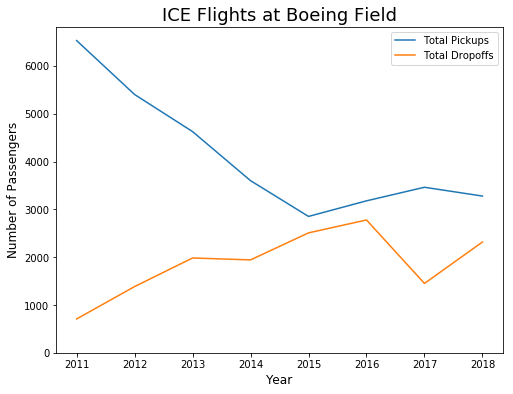

In [34]:
def plot(data):
    
    fig, ax = plt.subplots()
    
    for datum in data:
        ax = datum.plot(legend=True)
    
    ax.set_ylabel('Number of Passengers', fontsize=12)
    ax.set_ylim(0)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_title('ICE Flights at Boeing Field', fontsize=18)
    
    fig.savefig('../output/ICEFlights.png')
    return fig, ax

annual_KBFI_pickups.rename('Total Pickups', inplace=True)
annual_KBFI_dropoffs.rename('Total Dropoffs', inplace=True)

plot = plot([annual_KBFI_pickups, annual_KBFI_dropoffs]);

In [35]:
annual_non_criminal = KBFI_pickups[['NonCriminal']].resample('AS').sum()

In [36]:
annual_non_criminal['total'] = annual_KBFI_pickups
annual_non_criminal['percent'] = annual_non_criminal['NonCriminal']/annual_KBFI_pickups*100

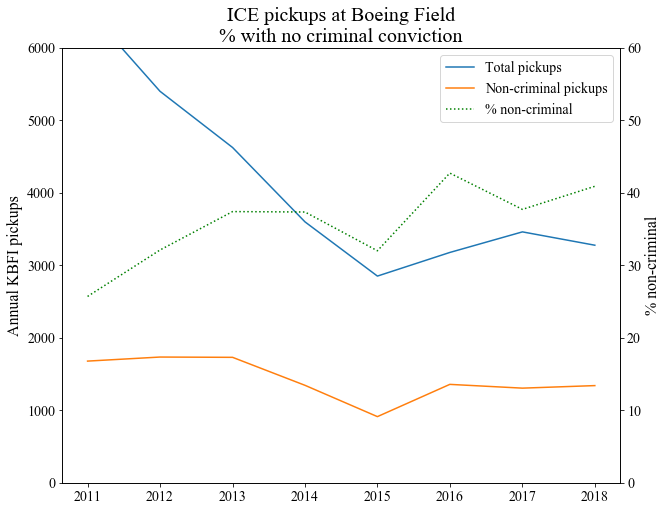

In [37]:
annual_data = annual_non_criminal['2011':'2018']
# monthly_data = monthly_non_criminal

plt.style.use([{'legend.frameon': True}])
plt.rc("font", family="Times New Roman")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

lns1 = ax1.plot(annual_data['total'], label='Total pickups')
lns2 = ax1.plot(annual_data['NonCriminal'], label='Non-criminal pickups')
ax1.set_ylim(0, 6000)
ax1.set_ylabel('Annual KBFI pickups', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

lns3 = ax2.plot(annual_data['percent'], label='% non-criminal', linestyle=':', color='green')
ax2.set_ylim(0,60)
ax2.set_ylabel('% non-criminal', fontsize=16)
ax2.tick_params(axis='y', labelsize=14)

lns = [lns1[0], lns2[0], lns3[0]]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, fontsize=14)

ax1.set_title('ICE pickups at Boeing Field\n% with no criminal conviction', fontsize=20)

fig.set_size_inches(10, 8)

plt.show()
fig.savefig('../output/NoCrim.png', dpi=100)

# Mapping

In [38]:
df.reset_index(inplace=True)

In [39]:
groupby = df.groupby(['MissionYear', 'R-T', 'PULOC', 'DropLoc'])

In [40]:
table = groupby.size().reset_index()

In [41]:
flights = groupby['MissionID'].nunique().reset_index()['MissionID']

In [42]:
table.columns = ['year', 'R-T', 'pickup_airport', 'dropoff_airport', 'passengers']

In [43]:
table['flights'] = flights

In [44]:
table.reset_index(drop=True, inplace=True)

In [45]:
all_kbfi = (table['pickup_airport'] == 'KBFI') | (table['dropoff_airport'] == 'KBFI')

In [46]:
table.to_csv('../output/flight_summary.csv.gz', index=False, compression='gzip', encoding='utf-8', sep='|')